In [ ]:
# -*- coding: utf-8 -*-
"""
Projeto de Machine Learning Completo - Predição de Preços de Casas na Califórnia
Este projeto implementa um pipeline completo de ML para predição de preços de imóveis
usando o dataset California Housing Prices.
"""

# Importações e configurações iniciais
from __future__ import division, print_function, unicode_literals
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuração de seeds para reprodutibilidade
np.random.seed(42)

# Configurações de plotagem
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Configuração de diretórios para salvar imagens
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """Função para salvar figuras com configurações padronizadas"""
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:

# ==============================================================================
# 1. CARREGAMENTO E EXPLORAÇÃO DOS DADOS
# ==============================================================================

import tarfile
import urllib.request

# URLs e caminhos para download dos dados
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Baixa e extrai o dataset de preços de casas da Califórnia
    """
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    """
    Carrega o dataset de preços de casas em um DataFrame
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Carregamento dos dados
fetch_housing_data()
housing = load_housing_data()

In [ ]:
# Exploração inicial dos dados
print("\n=== EXPLORAÇÃO INICIAL DOS DADOS ===")
print("Primeiras 5 linhas do dataset:")
housing.head()



=== EXPLORAÇÃO INICIAL DOS DADOS ===
Primeiras 5 linhas do dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
print("\nInformações gerais do dataset:")
housing.info()


Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
print("\nDistribuição da variável ocean_proximity:")
print(housing["ocean_proximity"].value_counts())




Distribuição da variável ocean_proximity:
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


In [ ]:
print("\nEstatísticas descritivas:")
housing.describe()



Estatísticas descritivas:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000



Gerando histogramas das variáveis...
Saving figure attribute_histogram_plots


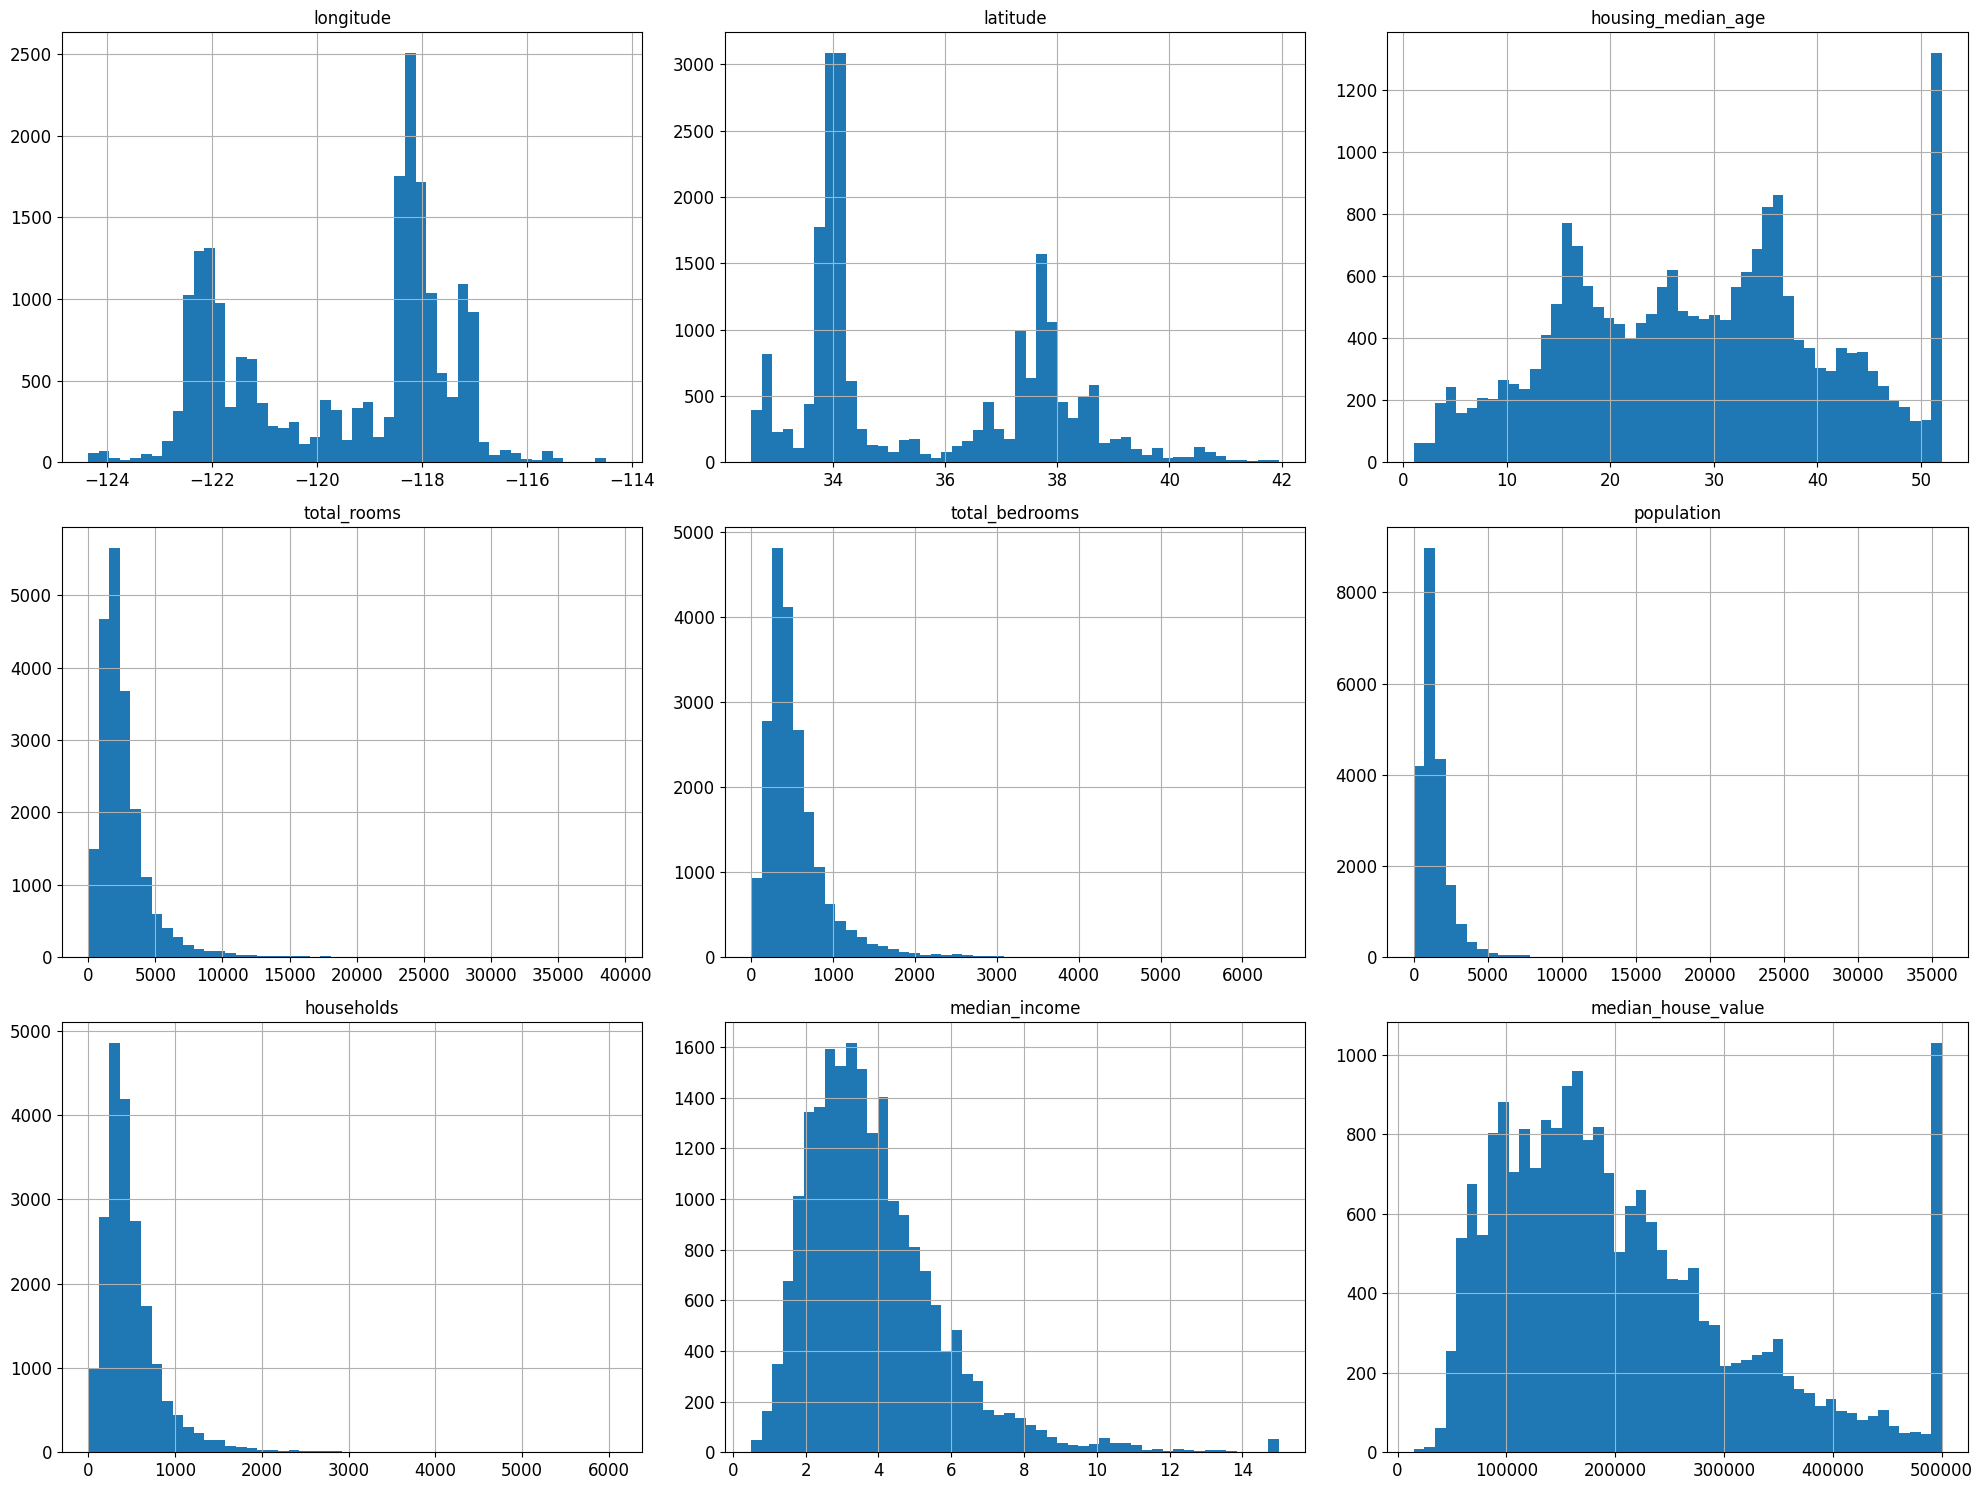

In [ ]:
# Visualização das distribuições das variáveis
print("\nGerando histogramas das variáveis...")
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()


=== DIVISÃO ESTRATIFICADA DOS DADOS ===


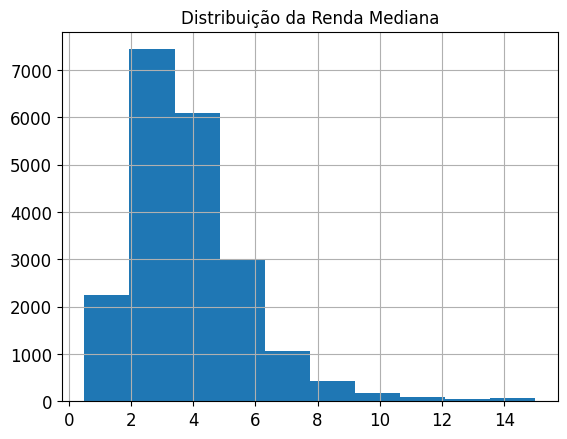

In [ ]:
# ==============================================================================
# 2. DIVISÃO ESTRATIFICADA DOS DADOS
# ==============================================================================

print("\n=== DIVISÃO ESTRATIFICADA DOS DADOS ===")

# Análise da distribuição de renda para criar estratos
housing["median_income"].hist()
plt.title("Distribuição da Renda Mediana")
plt.show()



In [ ]:
# Criação de categorias de renda para estratificação
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

print("Distribuição das categorias de renda:")
housing["income_cat"].value_counts()



Distribuição das categorias de renda:


,count
income_cat,
3,7236
2,6581
4,3639
5,2362
1,822


In [ ]:
# Divisão estratificada para manter proporções representativas
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Comparação entre divisão estratificada e aleatória
def income_cat_proportions(data):
    """Calcula proporções das categorias de renda"""
    return data["income_cat"].value_counts() / len(data)

train_set_random, test_set_random = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set_random),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

print("\nComparação entre divisão estratificada e aleatória:")
print(compare_props)

# Remoção da coluna auxiliar income_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


Comparação entre divisão estratificada e aleatória:
             Overall  Stratified    Random  Rand. %error  Strat. %error
income_cat                                                             
1           0.039826    0.039971  0.040213      0.973236       0.364964
2           0.318847    0.318798  0.324370      1.732260      -0.015195
3           0.350581    0.350533  0.358527      2.266446      -0.013820
4           0.176308    0.176357  0.167393     -5.056334       0.027480
5           0.114438    0.114341  0.109496     -4.318374      -0.084674



=== ANÁLISE EXPLORATÓRIA E VISUALIZAÇÃO ===
Gerando visualizações geográficas...
Saving figure housing_prices_scatterplot


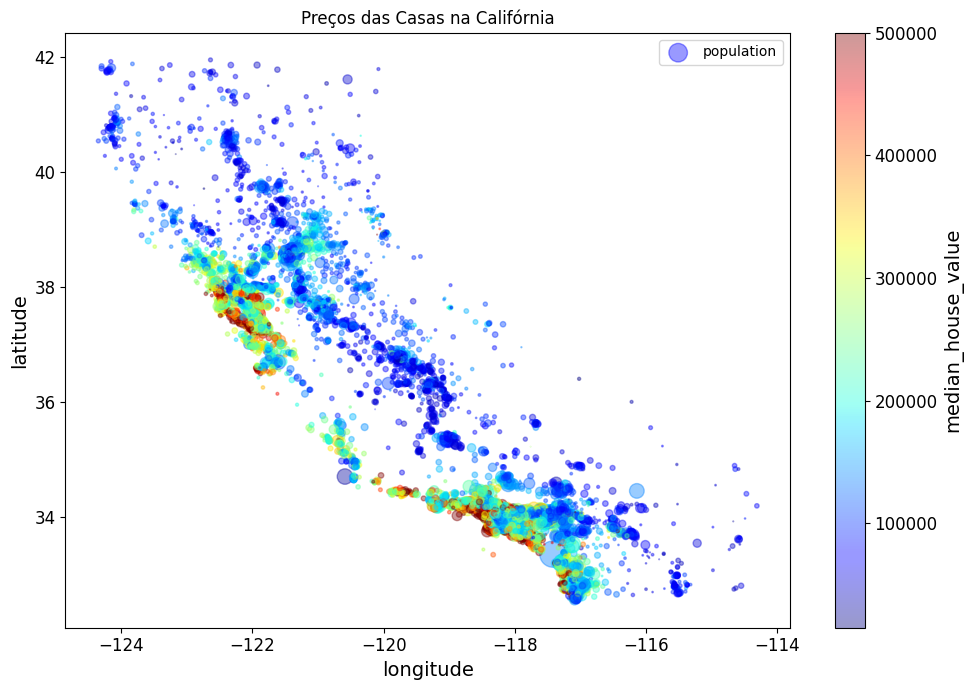


Correlações com median_house_value:
median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64
Saving figure scatter_matrix_plot


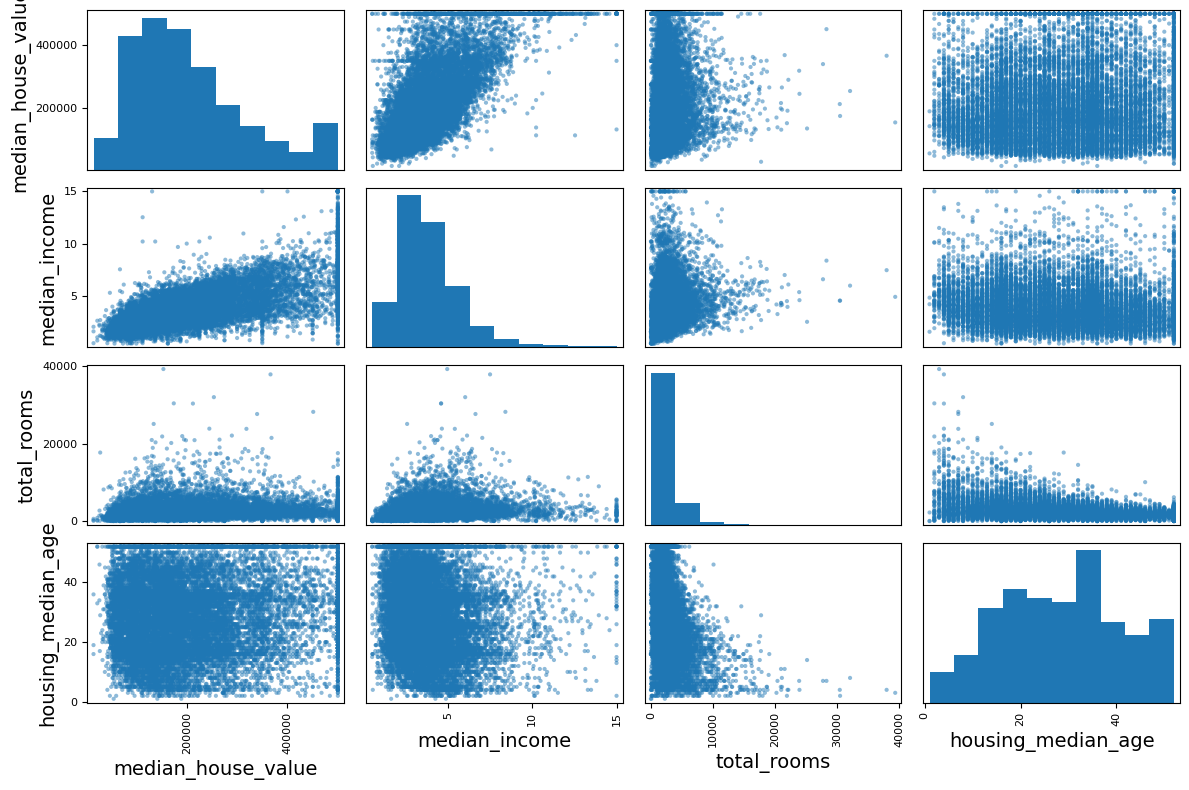


=== ENGENHARIA DE FEATURES ===

Correlações após engenharia de features:
median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


In [ ]:

# ==============================================================================
# 3. ANÁLISE EXPLORATÓRIA E VISUALIZAÇÃO
# ==============================================================================

print("\n=== ANÁLISE EXPLORATÓRIA E VISUALIZAÇÃO ===")

# Cópia dos dados de treino para exploração
housing = strat_train_set.copy()

# Visualizações geográficas
print("Gerando visualizações geográficas...")

# Scatter plot simples
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.title("Preços das Casas na Califórnia")
save_fig("housing_prices_scatterplot")
plt.show()

# Análise de correlações
housing_numerical = housing.drop('ocean_proximity', axis=1)
corr_matrix = housing_numerical.corr()

print("\nCorrelações com median_house_value:")
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# Matrix de scatter plots para variáveis principais
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")
plt.show()

# Criação de novas features (engenharia de features)
print("\n=== ENGENHARIA DE FEATURES ===")
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

# Recalculo das correlações com as novas features
housing_numerical = housing.drop('ocean_proximity', axis=1)
corr_matrix = housing_numerical.corr()
print("\nCorrelações após engenharia de features:")
print(corr_matrix["median_house_value"].sort_values(ascending=False))


In [ ]:

# ==============================================================================
# 4. PREPARAÇÃO DOS DADOS - PIPELINE DE TRANSFORMAÇÃO
# ==============================================================================

print("\n=== PREPARAÇÃO DOS DADOS ===")

# Separação de features e target
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Tratamento de valores ausentes
print("Dados ausentes por coluna:")
print(housing.isnull().sum())

# Transformador customizado para adicionar features combinadas
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Transformador customizado que adiciona features combinadas:
    - rooms_per_household: total_rooms / households
    - population_per_household: population / households
    - bedrooms_per_room: total_bedrooms / total_rooms (opcional)
    """
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Índices das colunas necessárias
        rooms_ix = 3  # total_rooms
        bedrooms_ix = 4  # total_bedrooms
        population_ix = 5  # population
        household_ix = 6  # households

        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Pipeline para variáveis numéricas
housing_num = housing.drop('ocean_proximity', axis=1)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # Preenchimento de valores ausentes
    ('attribs_adder', CombinedAttributesAdder()),   # Adição de features combinadas
    ('std_scaler', StandardScaler()),               # Padronização
])

# Pipeline completo (numérico + categórico)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Aplicação do pipeline aos dados de treino
print("Aplicando pipeline de transformação...")
housing_prepared = full_pipeline.fit_transform(housing)
print(f"Shape dos dados após transformação: {housing_prepared.shape}")



=== PREPARAÇÃO DOS DADOS ===
Dados ausentes por coluna:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64
Aplicando pipeline de transformação...
Shape dos dados após transformação: (16512, 16)


In [ ]:

# ==============================================================================
# 5. CONSTRUÇÃO E AVALIAÇÃO DE MODELOS PREDITIVOS
# ==============================================================================

print("\n=== CONSTRUÇÃO DE MODELOS PREDITIVOS ===")

# Função para avaliar modelos
def evaluate_model(y_true, y_pred, model_name):
    """
    Calcula e exibe métricas de avaliação para um modelo
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} - Métricas de Avaliação:")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"MAE: ${mae:,.2f}")
    print(f"R²: {r2:.4f}")

    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# 1. Regressão Linear
print("\n1. Treinando Regressão Linear...")
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_scores = evaluate_model(housing_labels, housing_predictions, "Regressão Linear")

# 2. Árvore de Decisão
print("\n2. Treinando Árvore de Decisão...")
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_scores = evaluate_model(housing_labels, housing_predictions, "Árvore de Decisão")

# 3. Random Forest
print("\n3. Treinando Random Forest...")
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_scores = evaluate_model(housing_labels, housing_predictions, "Random Forest")



=== CONSTRUÇÃO DE MODELOS PREDITIVOS ===

1. Treinando Regressão Linear...

Regressão Linear - Métricas de Avaliação:
RMSE: $68,627.87
MAE: $49,438.67
R²: 0.6482

2. Treinando Árvore de Decisão...

Árvore de Decisão - Métricas de Avaliação:
RMSE: $0.00
MAE: $0.00
R²: 1.0000

3. Treinando Random Forest...

Random Forest - Métricas de Avaliação:
RMSE: $18,650.70
MAE: $12,061.52
R²: 0.9740


In [ ]:

# ==============================================================================
# 6. VALIDAÇÃO CRUZADA
# ==============================================================================

print("\n=== VALIDAÇÃO CRUZADA ===")

def display_cross_val_scores(scores, model_name):
    """
    Exibe resultados da validação cruzada
    """
    print(f"\n{model_name} - Validação Cruzada (RMSE):")
    print(f"Scores: {scores}")
    print(f"Média: ${scores.mean():,.2f}")
    print(f"Desvio Padrão: ${scores.std():,.2f}")
    return scores

# Validação cruzada para todos os modelos
models = {
    "Regressão Linear": lin_reg,
    "Árvore de Decisão": tree_reg,
    "Random Forest": forest_reg
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, housing_prepared, housing_labels,
                           scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    cv_results[name] = display_cross_val_scores(rmse_scores, name)



=== VALIDAÇÃO CRUZADA ===

Regressão Linear - Validação Cruzada (RMSE):
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Média: $69,104.08
Desvio Padrão: $2,880.33

Árvore de Decisão - Validação Cruzada (RMSE):
Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Média: $71,629.89
Desvio Padrão: $2,914.04

Random Forest - Validação Cruzada (RMSE):
Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Média: $50,435.58
Desvio Padrão: $2,203.34


In [ ]:

# ==============================================================================
# 7. OTIMIZAÇÃO DE HIPERPARÂMETROS
# ==============================================================================

print("\n=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===")

# Grid Search para Random Forest (melhor modelo na validação cruzada)
print("\nOtimizando Random Forest com Grid Search...")

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Melhor score: {np.sqrt(-grid_search.best_score_):,.2f}")

# Análise da importância das features
feature_importances = grid_search.best_estimator_.feature_importances_

# Nomes das features (numéricas + categóricas one-hot encoded)
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
num_attribs = list(housing_num) + extra_attribs
cat_attribs_expanded = list(full_pipeline.named_transformers_["cat"].get_feature_names_out())
all_attribs = num_attribs + cat_attribs_expanded

print("\nImportância das Features:")
feature_importance_df = pd.DataFrame({
    'feature': all_attribs,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(feature_importance_df.head(10))

# Randomized Search para comparação
print("\nOtimizando com Randomized Search...")
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error',
                               random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

print(f"Melhores parâmetros (Random): {rnd_search.best_params_}")
print(f"Melhor score (Random): {np.sqrt(-rnd_search.best_score_):,.2f}")



=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===

Otimizando Random Forest com Grid Search...
Melhores parâmetros: {'max_features': 8, 'n_estimators': 30}
Melhor score: 49,898.99

Importância das Features:
                     feature  importance
7              median_income    0.379009
12    ocean_proximity_INLAND    0.165706
9   population_per_household    0.107031
0                  longitude    0.069654
1                   latitude    0.060421
8        rooms_per_household    0.054779
10         bedrooms_per_room    0.048203
2         housing_median_age    0.042188
5                 population    0.015849
4             total_bedrooms    0.015555

Otimizando com Randomized Search...
Melhores parâmetros (Random): {'max_features': 7, 'n_estimators': 180}
Melhor score (Random): 49,117.55


In [ ]:

# ==============================================================================
# 8. PIPELINE COMPLETO COM MODELO
# ==============================================================================

print("\n=== PIPELINE COMPLETO COM MODELO ===")

# Pipeline completo incluindo o modelo otimizado
complete_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', grid_search.best_estimator_)
])

# Treinamento do pipeline completo
print("Treinando pipeline completo...")
complete_pipeline.fit(housing, housing_labels)



=== PIPELINE COMPLETO COM MODELO ===
Treinando pipeline completo...


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(),
                                                  ['ocean_proximity'])])),
                ('model',
                 RandomForestRegressor(max_features=8, n_estimators=30,
                                       random_state=42))])

In [ ]:

# ==============================================================================
# 9. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
# ==============================================================================

print("\n=== AVALIAÇÃO FINAL ===")

# Preparação dos dados de teste
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Predição usando o pipeline completo
final_predictions = complete_pipeline.predict(X_test)

# Avaliação final
final_scores = evaluate_model(y_test, final_predictions, "Modelo Final (Teste)")

# Intervalo de confiança para o RMSE
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
confidence_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                                              loc=squared_errors.mean(),
                                              scale=stats.sem(squared_errors)))

print(f"\nIntervalo de confiança {confidence*100}% para RMSE: "
      f"[${confidence_interval[0]:,.2f}, ${confidence_interval[1]:,.2f}]")



=== AVALIAÇÃO FINAL ===

Modelo Final (Teste) - Métricas de Avaliação:
RMSE: $47,873.26
MAE: $31,811.15
R²: 0.8242

Intervalo de confiança 95.0% para RMSE: [$45,893.36, $49,774.47]


In [ ]:

# ==============================================================================
# 10. RESUMO DOS RESULTADOS
# ==============================================================================

print("\n" + "="*60)
print("RESUMO DOS RESULTADOS")
print("="*60)

results_summary = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Árvore de Decisão', 'Random Forest', 'RF Otimizado (Teste)'],
    'RMSE_CV': [cv_results['Regressão Linear'].mean(),
                cv_results['Árvore de Decisão'].mean(),
                cv_results['Random Forest'].mean(),
                final_scores['RMSE']],
    'Status': ['Underfitting', 'Overfitting', 'Bom', 'Final']
})

print(results_summary)

print(f"\nMelhor modelo: Random Forest Otimizado")
print(f"RMSE no conjunto de teste: ${final_scores['RMSE']:,.2f}")
print(f"R² no conjunto de teste: {final_scores['R2']:.4f}")

print("\nTop 5 features mais importantes:")
print(feature_importance_df.head())

print("\nPipeline completo salvo e pronto para uso em produção!")

# Exemplo de uso do pipeline completo para novas predições
print("\n=== EXEMPLO DE USO ===")
sample_data = X_test.iloc[:5]  # Primeiras 5 amostras do teste
sample_predictions = complete_pipeline.predict(sample_data)
sample_actual = y_test.iloc[:5]

comparison_df = pd.DataFrame({
    'Predição': sample_predictions,
    'Valor Real': sample_actual.values,
    'Erro Absoluto': np.abs(sample_predictions - sample_actual.values)
})

print("Comparação de predições vs valores reais:")
print(comparison_df)

print("\nProjeto de Machine Learning concluído com sucesso!")


RESUMO DOS RESULTADOS
                 Modelo       RMSE_CV        Status
0      Regressão Linear  69104.079982  Underfitting
1     Árvore de Decisão  71629.890097   Overfitting
2         Random Forest  50435.580921           Bom
3  RF Otimizado (Teste)  47873.260958         Final

Melhor modelo: Random Forest Otimizado
RMSE no conjunto de teste: $47,873.26
R² no conjunto de teste: 0.8242

Top 5 features mais importantes:
                     feature  importance
7              median_income    0.379009
12    ocean_proximity_INLAND    0.165706
9   population_per_household    0.107031
0                  longitude    0.069654
1                   latitude    0.060421

Pipeline completo salvo e pronto para uso em produção!

=== EXEMPLO DE USO ===
Comparação de predições vs valores reais:
        Predição  Valor Real  Erro Absoluto
0  488167.466667    500001.0   11833.533333
1  229946.666667    162500.0   67446.666667
2  209950.000000    204600.0    5350.000000
3  166976.666667    159700.0 